In [210]:
import numpy as np 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.metrics import silhouette_score
from datetime import date

In [211]:
def data_retrieval(threshold = 0.65):
    data_path = "./Data_Providers/"
    df_providers_class_content = pd.read_csv(data_path + 'content_overview_new_202509.csv')
    df_providers_class_service = pd.read_csv(data_path + 'service_overview_new_202509.csv')
    df_providers_class_content = df_providers_class_content[df_providers_class_content.columns[0:-1]].dropna()
    df_providers_class_service = df_providers_class_service[df_providers_class_service.columns[0:-1]].dropna()
    print(df_providers_class_content.describe()), print(df_providers_class_service.describe())
    df_new = pd.DataFrame()

    row = []

    for i in range(len(df_providers_class_service)):
        for j in range(len(df_providers_class_content)):
            if df_providers_class_content["instance"][j][0:-1] in df_providers_class_service.loc[i, "server"] and df_providers_class_content["feed"][j] == df_providers_class_service["feed"][i] and df_providers_class_content["date"][j] == df_providers_class_service["date"][i]:
        
                # build row
                row = {
                "feed": df_providers_class_service.loc[i, "feed"],
                "server": df_providers_class_service.loc[i, "server"],
                "map_matching": df_providers_class_content.loc[j, "map_matching"],
                "exclusive": df_providers_class_content.loc[j, "exclusive"],
                "redundant": df_providers_class_content.loc[j, "redundant"],
                "accidents": df_providers_class_service.loc[i, "accidents"],
                "hazards": df_providers_class_service.loc[i, "hazards"],
                "closures": df_providers_class_service.loc[i, "closures"],
                "freshness": df_providers_class_service.loc[i, "freshness"],
                "contribution": df_providers_class_service.loc[i, "contribution"],
                "usability": df_providers_class_service.loc[i, "usability"],
                "availability": df_providers_class_service.loc[i, "availability"],

                }
                row = pd.DataFrame([row])
                # append row to dataframe
                df_new = pd.concat([df_new, row])
          
        print("cycle i:", i, " out of ", len(df_providers_class_service))

    merged_df = df_new
    df_complete = merged_df
    df_complete['freshness'] = (df_complete['freshness'] - df_complete['freshness'].min()) / (df_complete['freshness'].max() - df_complete['freshness'].min())
    df = df_complete[df_complete.columns[2:]]
    corr_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.savefig("corr_matrix.png")
    plt.show()

    # Extract attributes with absolute correlation above 0.65 (excluding self-correlation)
    high_corr_cols = set()
    
    for col in corr_matrix.columns:
        for idx in corr_matrix.index:
            if col != idx and abs(corr_matrix.loc[idx, col]) > threshold:
                high_corr_cols.add(col)
                high_corr_cols.add(idx)

    # Convert to list
    high_corr_cols = list(high_corr_cols)
    print("Attributes with absolute correlation above 0.65:", high_corr_cols)

    # Optional: store these attributes in a new dataframe
    df_high_corr = df[high_corr_cols]

    df_subset = df

    # Plot the average value for each column
    df_subset.mean().plot(kind='bar', figsize=(12, 6))
    plt.ylabel('Average value')
    plt.title('Average Scores per Attribute')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("avg_attributes.png")
    plt.show()

    return df_subset, df_high_corr, df_subset.describe()

In [212]:
from sklearn.mixture import GaussianMixture

def cluster_gmm(df, a=1,b=1.960, grades = ['A+', 'A', 'B', 'C', 'D']):

    df = df[['map_matching', 'exclusive', 'redundant', 'accidents',
       'hazards', 'closures', 'freshness', 'contribution', 'usability',
       'availability']]

    # --- Fit GMM ---
    gmm = GaussianMixture(n_components=len(grades), covariance_type='full', random_state=42)
    df['cluster_GMM'] = gmm.fit_predict(df)

    # --- Probabilities for each cluster ---
    proba = gmm.predict_proba(df.drop(columns=['cluster_GMM']))
    df[[f'cluster_{i}_prob' for i in range(5)]] = proba

    # --- Cluster summary
    cluster_summary = df.groupby('cluster_GMM')[['map_matching', 'redundant', 'freshness','exclusive',
                                         'availability', 'contribution', 'usability']].agg(['mean', 'min', 'max', 'count'])

    mean_cols = cluster_summary.loc[:, pd.IndexSlice[:, 'mean']]
    mean_cols.columns = mean_cols.columns.droplevel(1)

    # Average mean score
    cluster_summary['average_mean'] = mean_cols.mean(axis=1)

    # Variance score
    cluster_variance = df.groupby('cluster_GMM')[['map_matching', 'redundant', 'exclusive',
                                          'availability', 'freshness', 'contribution', 'usability']].var()
    cluster_summary['variance_score'] = cluster_variance.mean(axis=1)

    # --- Extract means for custom scoring ---
    map_matching_mean = cluster_summary[('map_matching', 'mean')]
    exclusive_mean = cluster_summary[('exclusive', 'mean')]
    redundant_mean = cluster_summary[('redundant', 'mean')]
    availability_mean = cluster_summary[('availability', 'mean')]
    freshness_mean = cluster_summary[('freshness', 'mean')]
    contribution_mean = cluster_summary[('contribution', 'mean')]
    usability_mean = cluster_summary[('usability', 'mean')]

    # --- Custom score formula ---
    cluster_summary['custom_score'] = (
        map_matching_mean + exclusive_mean + availability_mean +
        freshness_mean + contribution_mean + usability_mean - redundant_mean    
    )

    # Rank clusters by custom score
    cluster_summary['custom_rank'] = cluster_summary['custom_score'].rank(ascending=False)
    cluster_summary_mean = cluster_summary.sort_values('custom_rank', ascending=True)

    # Assign grades (custom score)
    
    cluster_summary_mean['grade'] = pd.Series(grades[:len(cluster_summary_mean)],
                                          index=cluster_summary_mean.index)

    # --- Rank by variability ---
    cluster_summary_var = cluster_summary.sort_values('variance_score', ascending=True)
    cluster_summary_var['grade'] = pd.Series(grades[:len(cluster_summary_var)],
                                         index=cluster_summary_var.index)

    rows_lb = []
    rows_ub = []
    for i in range(len(grades)):
      rows_lb.append(a * cluster_summary_mean.custom_score[i] - b * np.sqrt(cluster_summary_var.variance_score[i]) )
    cluster_summary['threshold_lb'] = rows_lb

    for i in range(len(grades)):
      rows_ub.append(a * cluster_summary_mean.custom_score[i] + b * np.sqrt(cluster_summary_var.variance_score[i]) )
    cluster_summary['threshold_ub'] = rows_ub

    # Rank by threshold
    cluster_summary_thld = cluster_summary.sort_values('threshold_ub', ascending=False)
    cluster_summary_thld['grade'] = pd.Series(grades[:len(cluster_summary_thld)],
                                          index=cluster_summary_thld.index)

    score_pca = silhouette_score(df, df['cluster_GMM'])
    bic = gmm.bic(df[['map_matching', 'exclusive', 'redundant', 'accidents',
       'hazards', 'closures', 'freshness', 'contribution', 'usability',
       'availability']])
    aic = gmm.aic(df[['map_matching', 'exclusive', 'redundant', 'accidents',
       'hazards', 'closures', 'freshness', 'contribution', 'usability',
       'availability']])
    
    return df, cluster_summary_mean[['custom_score', 'grade']], cluster_summary_var[['variance_score', 'grade']], cluster_summary_thld[['threshold_lb','threshold_ub', 'grade']].sort_index(), score_pca, bic,aic

In [213]:
def cluster_kmeans(df, a=1,b=1.960,  grades = ['A+', 'A', 'B', 'C', 'D'] ):

    kmeans = KMeans(n_clusters=5, random_state=42)
    df['cluster'] = kmeans.fit_predict(df)

    cluster_summary = df.groupby('cluster')[['map_matching', 'redundant', 'freshness','exclusive', 'availability', 'contribution', 'usability']].agg(['mean', 'min', 'max', 'count'])
    mean_cols = cluster_summary.loc[:, pd.IndexSlice[:, 'mean']]

    # Rename columns for easier access (optional)
    mean_cols.columns = mean_cols.columns.droplevel(1)  # drop second level 'mean'

    # Now calculate average of the three feature means for each cluster
    cluster_summary['average_mean'] = mean_cols.mean(axis=1)

    cluster_variance = df.groupby('cluster')[['map_matching', 'redundant', 'exclusive', 'availability', 'freshness', 'contribution', 'usability']].var()
    cluster_summary['variance_score'] = cluster_variance.mean(axis=1)

    # Extract individual mean values
    map_matching_mean = cluster_summary[('map_matching', 'mean')]
    exclusive_mean = cluster_summary[('exclusive', 'mean')]
    redundant_mean = cluster_summary[('redundant', 'mean')]
    availability_mean = cluster_summary[('availability', 'mean')]
    freshness_mean = cluster_summary[('freshness', 'mean')]
    contribution_mean = cluster_summary[('contribution', 'mean')]
    usability_mean = cluster_summary[('usability', 'mean')]
    # Apply the custom scoring formula
    cluster_summary['custom_score'] = map_matching_mean + exclusive_mean + availability_mean + freshness_mean + contribution_mean + usability_mean - redundant_mean

    # Rank clusters by custom score
    cluster_summary['custom_rank'] = cluster_summary['custom_score'].rank(ascending=False)

    # Sort clusters by average_mean descending (best quality first)
    cluster_summary_mean = cluster_summary.sort_values('custom_rank', ascending=True)

    # Define grades to assign by rank
 

    # Assign grades based on rank position
    cluster_summary_mean['grade'] = pd.Series(grades[:len(cluster_summary_mean)], index=cluster_summary_mean.index)
    cluster_summary_mean[['custom_score', 'grade']]

    # Sort clusters by variability ascending (best quality first)
    cluster_summary_var = cluster_summary.sort_values('variance_score', ascending=True)

    # Define grades to assign by rank
  

    # Assign grades based on rank position
    cluster_summary_var['grade'] = pd.Series(grades[:len(cluster_summary_var)], index=cluster_summary_var.index)
    cluster_summary_var[['variance_score', 'grade']]
    cluster_summary['threshold'] = np.zeros(5)
    rows_lb = []
    rows_ub = []
    for i in range(5):
        rows_lb.append(a * cluster_summary_mean.custom_score[i] - b * np.sqrt(cluster_summary_var.variance_score[i]) )
    cluster_summary['threshold_lb'] = rows_lb

    for i in range(5):
        rows_ub.append(a * cluster_summary_mean.custom_score[i] + b * np.sqrt(cluster_summary_var.variance_score[i]) )
    cluster_summary['threshold_ub'] = rows_ub

    # Sort clusters by variability ascending (best quality first)
    cluster_summary_thld= cluster_summary.sort_values('threshold_ub', ascending=False)
  

    # Assign grades based on rank position
    cluster_summary_thld['grade'] = pd.Series(grades[:len(cluster_summary_thld)], index=cluster_summary_thld.index)

    score_pca = silhouette_score(df, df['cluster'])
    
    return df, cluster_summary_mean[['custom_score', 'grade']], cluster_summary_var[['variance_score', 'grade']], cluster_summary_thld[['threshold_lb', 'threshold_ub','grade']].sort_index(), score_pca


In [214]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D  # Needed even if not directly used

def plot(df, var_name):


    fig = plt.figure(figsize=(18, 6))  # Wider layout for side-by-side

    # Define your triplets and titles
    plot_configs = [
    ('accidents', 'hazards', 'closures', 'Incident Coverage'),
    ('exclusive', 'redundant', 'contribution', 'Data Richness'),
    ('freshness', 'availability', 'map_matching', 'Service Performance')]

    # Loop to create subplots
    for idx, (x_col, y_col, z_col, title) in enumerate(plot_configs, start=1):
        ax = fig.add_subplot(1, 3, idx, projection='3d')
    
        scatter = ax.scatter(
            df[x_col],
            df[y_col],
            df[z_col],
            c=df[var_name],
            cmap='tab10',
            s=50,
            alpha=0.8
        )
    
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)

        # Apply consistent inversion logic if needed (edit per axis logic)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.invert_zaxis()
    
        ax.set_title(title)

    # Shared legend (outside of plot area)
    handles = [
        Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
        for i in sorted(df[var_name].unique())
    ]

    fig.legend(handles=handles, title='Clusters', loc='center right', bbox_to_anchor=(1.05, 0.5))
    fig.suptitle('3D Scatter Plots by Dimension Group', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 1])  # shrink plot area slightly more
    fig.subplots_adjust(wspace=0.3)        # increase horizontal space between subplots
    plt.savefig('3d_plot.png')
    plt.show()


In [215]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

def plot_separate_3d(df, var_name='cluster', cluster=0):
    """
    Creates 3 separate 3D scatter plots and saves them individually.
    Highlights cluster 0 in red in each plot.
    """

    # Define the 3 plot configurations: (x, y, z, title, filename)
    plot_configs = [
        ('accidents', 'hazards', 'closures', 'Incident Coverage', 'plot_incident_coverage'+ str(cluster)+'.png'),
        ('exclusive', 'redundant', 'contribution', 'Data Richness', 'plot_data_richness'+ str(cluster)+'.png'),
        ('freshness', 'availability', 'map_matching', 'Service Performance', 'plot_service_performance'+ str(cluster)+'.png')
    ]

    for x_col, y_col, z_col, title, filename in plot_configs:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot all points in light gray
        ax.scatter(df[x_col], df[y_col], df[z_col], c='lightgray', s=40, alpha=0.5, label='Your Clusters')

        # Highlight cluster 0 in red
        cluster0 = df[df[var_name] == cluster]
        ax.scatter(cluster0[x_col], cluster0[y_col], cluster0[z_col], c='red', s=60, alpha=0.9, label='Your Cluster')

        # Labels and title
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)
        ax.set_title(title)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.invert_zaxis()

        # Legend
        handles = [
            Line2D([0], [0], marker='o', color='w', label='Other Clusters',
                   markerfacecolor='lightgray', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='Your Cluster',
                   markerfacecolor='red', markersize=8)
        ]
        ax.legend(handles=handles, loc='best')

        # Save the figure
        plt.tight_layout()
        plt.savefig(filename)
        plt.close(fig)  # Close figure to free memory

    print("✅ 3 separate 3D plots saved successfully.")



In [216]:
def market_requirements(grades = ["D", "C", "B", "A", "A+"]):

    market_req = pd.DataFrame({"Accuracy_lb": [0, 0.15, 0.5,0.85,0.95],"Completeness_lb": [0,0.10,0.4,0.6,0.90],"Correctness_lb": [0,0.15,0.5,0.85,0.95], "Availability_lb": [0,0.85,0.95,0.97,0.99], "Timelineness_lb": [0,0.15,0.8,0.85,0.95], "Usability_lb": [0,0.15,0.5,0.85,0.95] , 
                              "Accuracy_ub": [0.15, 0.50, 0.85,0.95,1],"Completeness_ub": [0.1,0.4,0.6,0.9,1],"Correctness_ub": [0.15,0.5,0.85,0.95,1], "Availability_ub": [0.85,0.95,0.97,0.99,1], "Timelineness_ub": [0.15,0.8,0.85,0.95,1], "Usability_ub": [0.15,0.5,0.85,0.95,1] })
    market_req['Classification'] = ["D", "C", "B", "A", "A+"]

    
    columns = ['Accuracy_lb', 'Completeness_lb', 'Correctness_lb', 'Availability_lb',
       'Timelineness_lb', 'Usability_lb']
    market_req_thld_lb = []
    market_req_thld_ub = []

    for idx in range(len(grades)):
        row_lb = 0
        row_ub = 0

        for j in range(len(columns)):
            row_lb += market_req[market_req.columns[j]][market_req['Classification']==grades[idx]] 
            row_ub += market_req[market_req.columns[j + len(grades)]][market_req['Classification']==grades[idx]]

        market_req_thld_lb.append(row_lb)
        market_req_thld_ub.append(row_ub)

    
    return market_req_thld_lb, market_req_thld_ub

In [217]:
def thresholds(df, w_data = 0.25, w_market= 0.75, grades = ['D', 'C', 'B', 'A', 'A+']):
    
    df_clus, df_clus_mean, df_clus_var, df_clus_thld, score_gmm, bic, aic =  cluster_gmm(df)
    df_kmean, df_kmean_mean,df_kmean_var, df_kmeans_thld, kmean_metric = cluster_kmeans(df)

    if score_gmm > kmean_metric:
        var_name = 'cluster_GMM'
        plot(df_clus, var_name)
        print ("Silhouette score: " , score_gmm)
        thld_market_req_lb,thld_market_req_ub = market_requirements(grades)
        df_clus_thld = df_clus_thld.sort_values(['threshold_ub'], ascending=True)
        flat_list_ub = [x.iloc[0] for x in thld_market_req_ub] 
        flat_list_ub = [float(x) for x in flat_list_ub]
        df_clus_thld['threshold_ub'] = w_data * df_clus_thld['threshold_ub']  + w_market * np.array(flat_list_ub)
        flat_list_lb = [x.iloc[0] for x in thld_market_req_lb] 
        flat_list_lb = [float(x) for x in flat_list_lb]
        df_clus_thld['threshold_lb'] = w_data * df_clus_thld['threshold_lb']  + w_market * np.array(flat_list_lb)
    

    else:
        var_name = 'cluster'
        plot(df, var_name)
        print ("Silhouette score: " , kmean_metric)
        thld_market_req_lb,thld_market_req_ub = market_requirements(grades)
        df_kmeans_thld = df_kmeans_thld.sort_values(['threshold_ub'], ascending=True)
        flat_list_ub = [x.iloc[0] for x in thld_market_req_ub] 
        flat_list_ub = [float(x) for x in flat_list_ub]
        df_clus_thld['threshold_ub'] = w_data * df_kmeans_thld['threshold_ub']  + w_market * np.array(flat_list_ub)
        flat_list_lb = [x.iloc[0] for x in thld_market_req_lb] 
        flat_list_lb = [float(x) for x in flat_list_lb]
        df_clus_thld['threshold_lb'] = w_data * df_kmeans_thld['threshold_lb']  + w_market * np.array( flat_list_lb)
    
    return df_clus_thld


In [218]:
def analyze_cluster(cluster_id, df_mean, df_var, df_thld):
    # Make sure we're working with single rows as Series
    mean_row = df_mean.iloc[cluster_id]
    var_row = df_var.iloc[cluster_id]
    thld_row = df_thld.iloc[cluster_id]
    
    recommendations = []
     
    # Custom score
    val_mean = mean_row['grade'].values
    if val_mean in ['D', 'C', 'B']:
        recommendations.append(
        f"Increase custom_score from {mean_row['custom_score'].values[0]:.3f} to improve grade ({mean_row['grade'].values[0]} → higher)."
        )

    val_var = var_row['grade'].values
    # Variance score
    if val_var in ['D', 'C', 'B']:
        recommendations.append(
            f"Reduce variance_score from {var_row['variance_score'].values[0]:.5f} to improve stability ({var_row['grade'].values[0]} → higher)."
            )

    # Threshold
    val_thld = thld_row['grade'].values
    if val_thld in ['D', 'C', 'B']:
        recommendations.append(
            f"Increase thresholds from {thld_row['threshold_lb'].values[0]:.3f}-{thld_row['threshold_ub'].values[0]:.3f} to improve grade ({thld_row['grade'].values[0]} → higher)."
        )


    if not recommendations:
            recommendations.append("Cluster is performing very well across all metrics (A/A+).")
    
    return recommendations


def cluster_improvement_plan(df_mean, df_var, df_thld):
    plan = {}
    for clus in df_mean.index:
        plan[clus] = analyze_cluster(clus, df_mean, df_var, df_thld)
    return plan


In [ ]:
def create_report(cluster, df, df_clus_mean,df_clus_var,df_clus_thld, dist_d,dist_m):
    # === Basic stats ===
    summary = df_describe.T
    missing = df.isna().sum()
    types = df.dtypes

 # === Build markdown ===


    # === Build markdown ===
    md = "# 📊 Data Summary Report\n\n"
    md += f"**Total Rows:** {len(df)}\n\n"
    md += f"**Total Columns:** {df.shape[1]}\n\n"
    md += f"**Clusters (grades):** {['A+', 'A', 'B', 'C', 'D']}\n\n"
   
    md += f"**Your feed name:** {'TBD'}\n\n"
    md += f"**Date report generated:** {date.today()}\n\n"
   
    md += f"**Your Cluster (grade):** {'TBD'}\n\n"
   



    md += "\n## 📈 Descriptive Statistics\n\n"
    md += summary.to_markdown() + "\n\n"

    # === Simple natural-language summary ===
    md += "![Complete Attribute Summary ](avg_attributes.png)\n\n"

    # Compute correlation matrix
    corr = df.corr()

    # Flatten upper triangle of correlation matrix to avoid duplicates and self-correlations
    corr_pairs = (
        corr.where(~np.eye(corr.shape[0], dtype=bool))  # mask diagonal
            .stack()  # flatten to Series
            .abs()    # absolute value
            .sort_values(ascending=False)  # sort by strength
    )

    # Take top 5 strongest correlations
    top_corrs = corr_pairs.head(5)

    # Write Markdown table
    md += "| Feature 1 | Feature 2 | Top Correlation |\n"
    md += "|------------|------------|-------------|\n"
    for (f1, f2), val in top_corrs.items():
        md += f"| {f1} | {f2} | {val:.3f} |\n"

    # Optional textual summary
    most_corr = top_corrs.idxmax()
    md += f"\n- Among the top 5 strongest correlation is between **{most_corr[0]}** and **{most_corr[1]}** (r = {top_corrs.max():.3f})\n"

    # Optional textual summary
    md += "\n### 🧠 Interpretation\n"
    if not corr.empty:
        most_corr = top_corrs.idxmin()
        md += f"\n- Among the top 5 strongest correlation the weakest is between **{most_corr[0]}** and **{most_corr[1]}** (r = {top_corrs.min():.3f})\n"
    else:
        md += "- No significant correlations detected among numeric variables.\n"


    # === Simple natural-language summary ===
    md += "![Complete Correlation Matrix](corr_matrix.png)\n\n"


    md += "# 📊 Data grouping visualisation\n\n"

    md += "![Global grouping](3d_plot.png)\n\n"

    md += f"# 📊 Data group {cluster} visualisation\n\n"
    md += f"![Performance](plot_service_performance{cluster}.png)\n\n"
    md += f"![Data richness](plot_data_richness{cluster}.png)\n\n"
    md += f"![Incident coverage](plot_incident_coverage{cluster}.png)\n\n"



    plan = cluster_improvement_plan(df_clus_mean, df_clus_var, df_clus_thld)
    for clus, recs in plan.items():
        if clus == cluster:
            md += f"\n\n## 🧭 Cluster {clus} Recommendations\n"
            for r in recs:
                md += f"- {r}\n"


    # === Save as Markdown file ===
    with open("data_report.md", "w", encoding="utf-8") as f:
        f.write(md)

    print("✅ Markdown report saved as 'data_report.md'")

       map_matching    exclusive    redundant
count   9114.000000  9114.000000  9114.000000
mean       0.840237     0.474961     0.052067
std        0.335768     0.461432     0.114436
min        0.000000     0.000000     0.000000
25%        0.944591     0.000000     0.000000
50%        0.983904     0.477464     0.000000
75%        0.997986     0.987116     0.054537
max        1.000000     1.000000     1.000000
       availability     freshness  contribution    usability        frc_0  \
count   7982.000000   7982.000000   7982.000000  7982.000000  7982.000000   
mean       0.891519    666.559122      0.050067     0.295489     0.086531   
std        0.288455   2072.644481      0.122592     0.325912     0.208425   
min        0.000000      0.000000      0.000000     0.000000     0.000000   
25%        0.995210      0.570000      0.000000     0.000000     0.000000   
50%        0.999772      5.510000      0.000028     0.222054     0.000000   
75%        1.000000    113.600000      0.029075

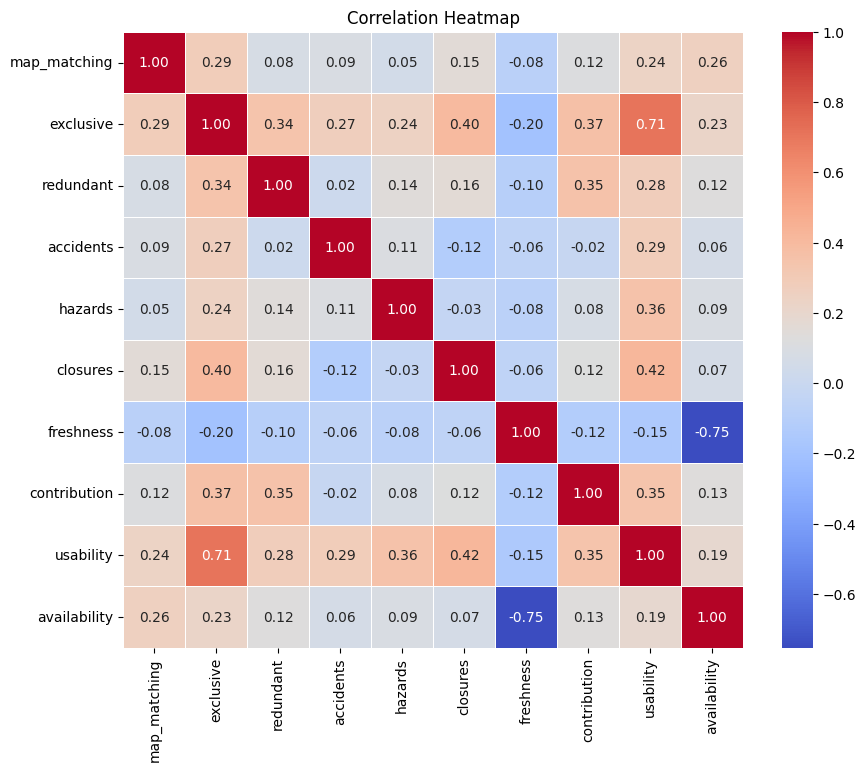

Attributes with absolute correlation above 0.65: ['exclusive', 'availability', 'usability', 'freshness']


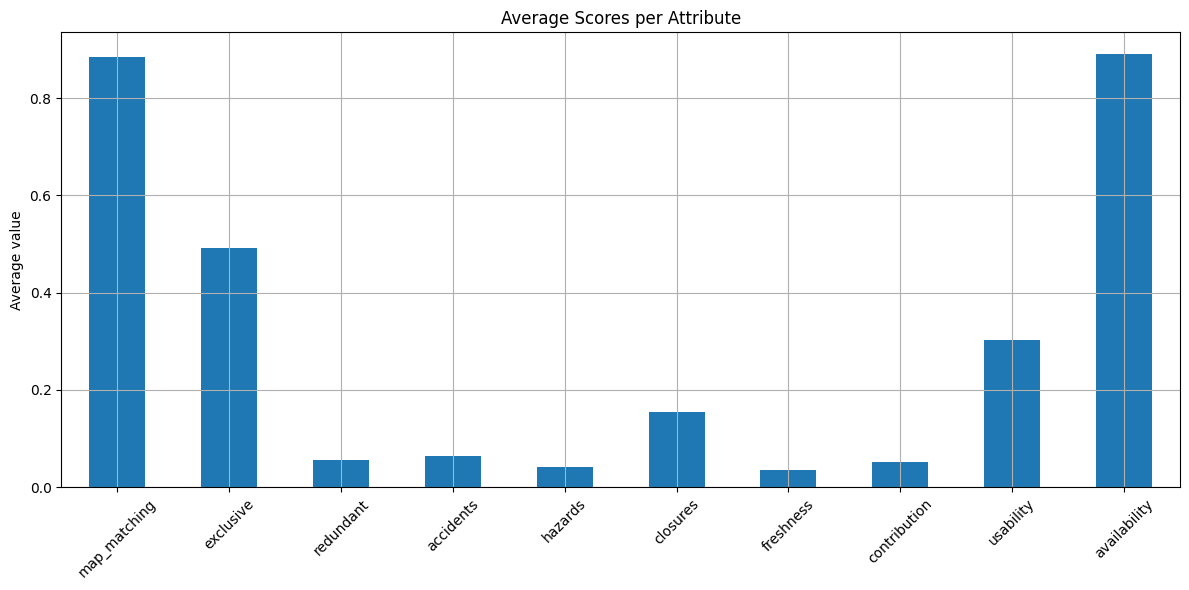

In [220]:
cluster = 0
dist_d = 0.3
dist_m = 0.7
df, corr, df_describe = data_retrieval()

✅ 3 separate 3D plots saved successfully.


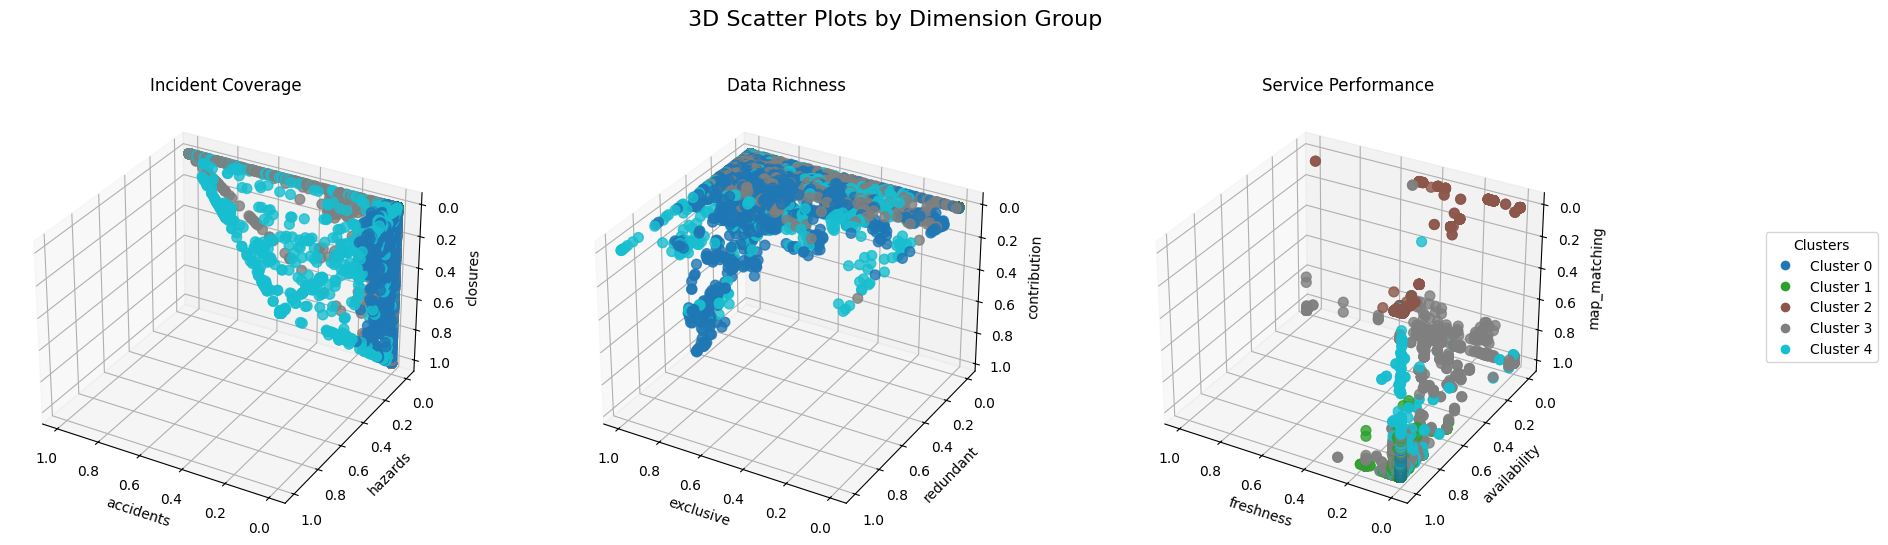

Silhouette score:  0.7133649163979021
✅ Markdown report saved as 'data_report.md'


In [221]:
df_clus, df_clus_mean, df_clus_var, df_clus_thld, score_gmm, bic, aic =  cluster_gmm(df)
df_kmean, df_kmean_mean, df_kmean_var, df_kmean_thld, score = cluster_kmeans(df)
if score_gmm > score:
        
    plot_separate_3d(df_clus, 'cluster_GMM', cluster)
    df_clus_thld = thresholds(df,dist_d, dist_m)
    create_report(cluster, df, df_clus_mean, df_clus_var, df_clus_thld, dist_d, dist_m)

else:
    plot_separate_3d(df_kmean, 'cluster', cluster)
    df_clus_thld = thresholds(df,dist_d, dist_m)
    create_report(cluster, df, df_clus_mean, df_clus_var, df_clus_thld, dist_d, dist_m)